In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.neighbors import NearestNeighbors

## Generating input files and batch scripts

In [10]:
def gen_sensor_arr(fidelity):
    """
    Function that generates a grid array of sensors in the domain [40,42] X [-112, -108.38] with the desired fidelity value
    
    Inputs
    ------
    fidelity (float) : desired sensor fidelity
    
    Returns
    -------
    sensors (np.array) : grid array of sensors with desired fidelity value
    """
    sensors = np.array([[41.,-110.19,fidelity,2.,0.],
                        [41.,-109.19,fidelity,2.,0.],
                        [41.,-111.19,fidelity,2.,0.],
                        [41.5,-110.19,fidelity,2.,0.],
                        [41.5,-109.19,fidelity,2.,0.],
                        [41.5,-111.19,fidelity,2.,0.],
                        [40.5,-110.19,fidelity,2.,0.],
                        [40.5,-109.19,fidelity,2.,0.],
                        [40.5,-111.19,fidelity,2.,0.]])
    
    return sensors

def write_input_file(file, nlpts_data, nlpts_space, ndata, lat_range, long_range, depth_range, mag_range, sensors, sampling_file):
    """
    Writes an input file for eig_calc.py using the specified function parameters
    
    Inputs
    ------
    file          (str) : filename of input file (with .dat file extension)
    nlpts_data    (int) : number of synthetic events to generate
    nlpts_space   (int) : number of points to use in space discretization
    ndata         (int) : number of data realizations based on synthetic events to generate
    lat_range     (np.array) : tuple specifying latitude range to consider in analysis
    long_range    (np.array) : tuple specifying longitude range to consider in analysis
    depth_range   (np.array) : tuple specifying depth range to consider in analysis
    mag_range     (np.array) : tuple specifying magnitude range to consider in analysis
    sensors       (np.array) : array of sensors
    sampling_file (str) : name of file where prior and importance distribution sampling functions are stored.
                          Should be same directory as eig_calc.py otherwise problems will occur.
                          Currently equires a newline delimiter at the end of the str or the script will throw errors.
    
    Returns
    -------
    Writes input file to working directory with name {file}
    """
    writedata=open(file,"w+")
    writedata.write(str(np.int(nlpts_data)) + "\n")
    writedata.write(str(np.int(nlpts_space)) + "\n")
    writedata.write(str(np.int(ndata)) + "\n")
    
    #,max_line_width=1000 to keep numppy from splitting the sensor description up onto multiple lines.
    writedata.write((np.array2string(lat_range,separator=',',max_line_width=1000)).replace('[','').replace(']','').replace(' ', '') + "\n")
    writedata.write((np.array2string(long_range,separator=',',max_line_width=1000)).replace('[','').replace(']','').replace(' ', '') + "\n")
    writedata.write((np.array2string(depth_range,separator=',',max_line_width=1000)).replace('[','').replace(']','').replace(' ', '') + "\n")
    writedata.write((np.array2string(mag_range,separator=',',max_line_width=1000)).replace('[','').replace(']','').replace(' ', '') + "\n")

    # Write file to sample with
    sampling_file = writedata.write(sampling_file)
    
    #rest of lines are sensors
    writedata.write((np.array2string(sensors,separator=',',max_line_width=1000)).replace('[','').replace('],','').replace(']','').replace(' ', '') + "\n")

    #lat, long, measurement noise std, length of data vector for sensor, sensor type
    #write teh new sensor
    
    writedata.close()
    return

def gen_slurmstr(in_path, out_path, nodes=8, cores=32):
    """
    Writes slurm batch file to working directory (should be same directory as eig_calc.py) 
    that runs eig_calc with the specified input and output files.
    
    Inputs
    ------
    in_path  (str) : path to eig_calc.py input file (should be .dat file)
    out_path (str) : desired path for eig_calc.py to save outputs (should be .npz file)
    nodes    (int) : number of desired nodes to use for running job
    cores    (cores) : number of cores each node should use for running job
    
    Returns
    -------
    out_path (str) : 
    """
    
    return f"""#!/bin/bash
    ## Do not put any commands or blank lines before the #SBATCH lines
    #SBATCH --nodes={nodes}                   # Number of nodes - all cores per node are allocated to the job
    #SBATCH --time=03:00:00              # Wall clock time (HH:MM:SS) - once the job exceeds this time, the job will be terminated (default is 5 minutes)
    #SBATCH --account=FY210056           # WC ID
    #SBATCH --job-name=fidel_{i}          # Name of job
    #SBATCH --partition=short,batch            # partition/queue name: short or batch
                                          #            short: 4hrs wallclock limit
                                          #            batch: nodes reserved for > 4hrs (default)
    #SBATCH --qos=normal                  # Quality of Service: long, large, priority or normal
                                          #           normal: request up to 48hrs wallclock (default)
                                          #           long:   request up to 96hrs wallclock and no larger than 64nodes
                                          #           large:  greater than 50% of cluster (special request)
                                          #           priority: High priority jobs (special request)
    #SBATCH --export=ALL                 # export environment variables form the submission env (modules, bashrc etc)
   
    nodes=$SLURM_JOB_NUM_NODES           # Number of nodes - the number of nodes you have requested (for a list of SLURM environment variables see "man sbatch")
    cores={cores}                             # Number MPI processes to run on each node (a.k.a. PPN)
                                         # CTS1 has 36 cores per node, skybridge 16
   
    mpiexec --bind-to core --npernode $cores --n $(($cores*$nodes)) python3 -u eig_calc.py {in_path} {out_path} 1
    """

# Write 21 input files and slurm execution scripts with fidelities in between -5 and 5
for i in np.linspace(-5,5,21):
    sensors = gen_sensor_arr(i)
    it = str(np.round(i,2)).replace('.','-')
    in_path = f'tight_fidelity_in/fidelity_inputs_{it}.dat'
    out_path = f'tight_fidelity_out/fidelity_outputs_{it}.npz
    
    write_input_file(in_path, 
                     4096, 
                     32768, 
                     16, 
                     np.array([40,42]), 
                     np.array([-112, -108.38]),
                     np.array([0,40]),
                     np.array([.5,10]),
                     sensors,
                     'unif_prior.py\n')'
    slurm_str = gen_slurmstr(in_path, out_path)
    with open(f'tight_fidelity_batch_{it}.bash', 'w+') as f:
        f.write(slurm_str)
    
    with open('fidelity_runs.bash', 'a+')as f:
        f.write(f'sbatch fidelity_batch_{i}.bash\n')

## Visualizing eig_calc outputs

In [4]:
# Analysis domains
lat_range = [40,42]
long_range = [-112,-108.38]
mag_range = [.5,10]
depth_range = [0,40]

### Information gain surface as affected by sensor fidelity

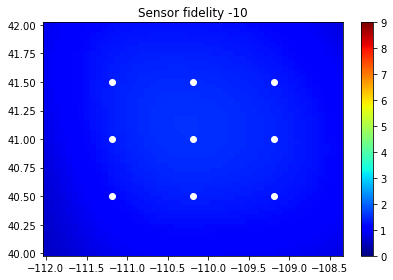

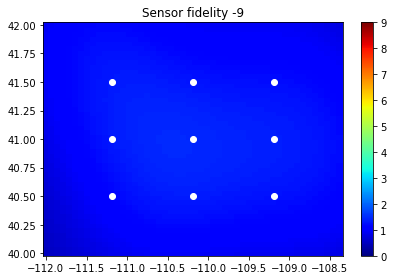

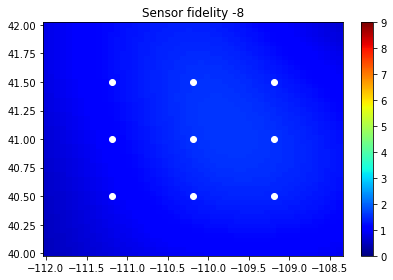

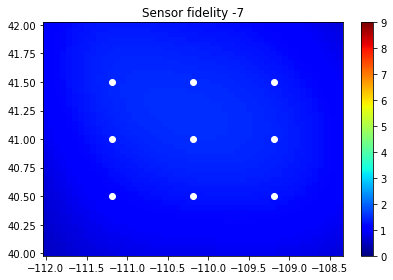

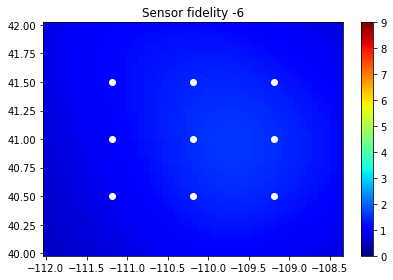

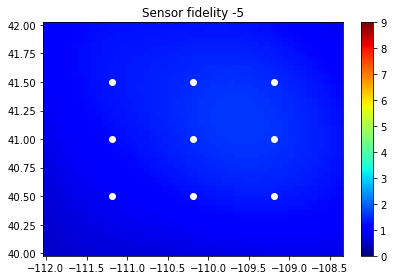

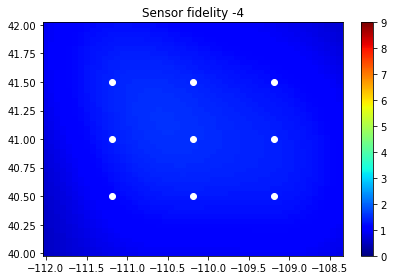

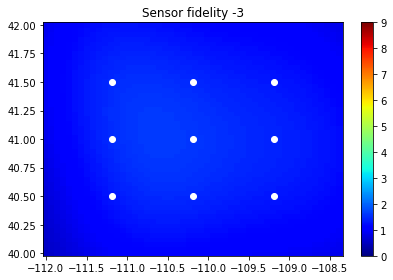

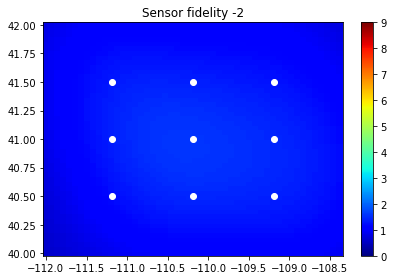

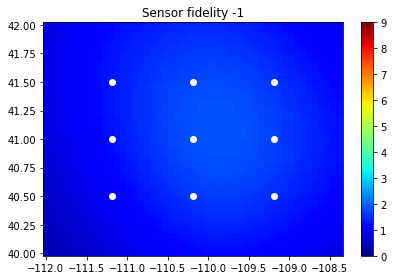

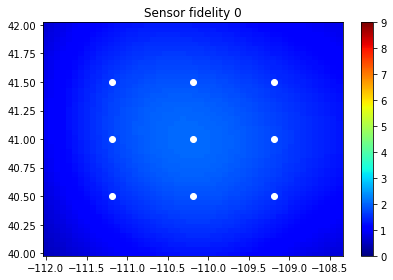

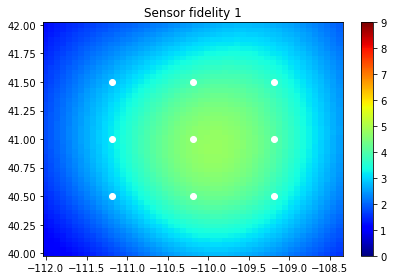

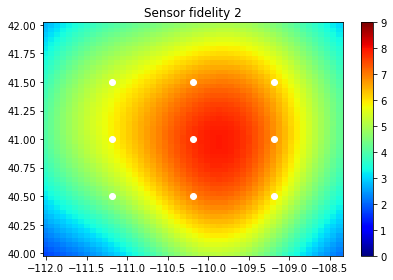

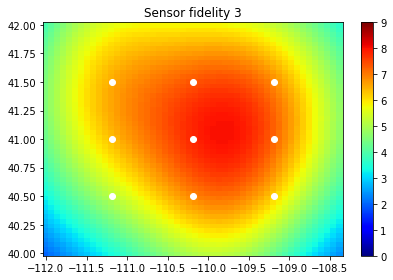

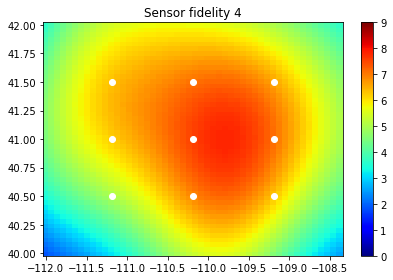

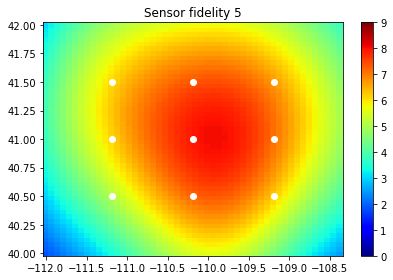

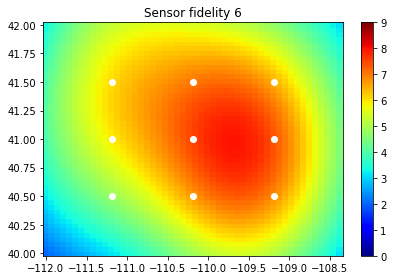

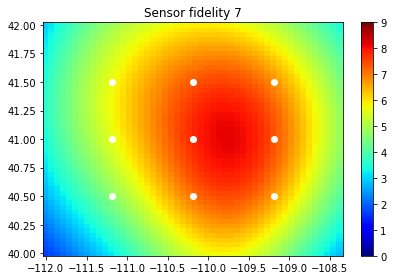

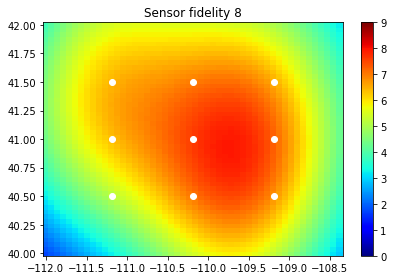

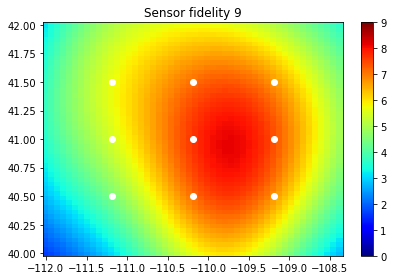

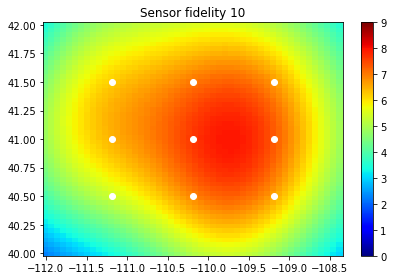

In [6]:
# List to store eig values
eigs = []

# Loop through each output file (filenames and loop values will need to change for different analyes)
for fid in range(-10,11):
    # Load data
    res = np.load(f'fidelity_out_extparams/fidelity_outputs_{fid}.npz')
    # Pull out information gains from each synthetic event
    ig = res['ig'].reshape((512,64)).mean(axis=1)
    # Pull out sensor network used in analysis
    net = res['sensors'][:,:2]
    # Store eig result of analysis
    eigs.append(res['eig'])

    # Gaussian process model to generate ig surface
    model = GPR()
    model.fit(res['theta_data'], ig)

    # Meshgrid that covers the whole domain to use for surface prediction lat/long inputs
    x = np.linspace(lat_range[0], lat_range[1])
    y = np.linspace(long_range[0], long_range[1])
    xv, yv = np.meshgrid(x, y)
    xy = np.vstack([xv.ravel(), yv.ravel()]).T

    # Fill in desired depth and magnitude constants to predict on
    domain = np.zeros((len(xy),4))
    domain[:,:2] = xy
    domain[:,2] = 0
    domain[:,3] = .5

    # Make ig predictions for surface visualization
    preds = model.predict(domain)
    # Plot
    im = plt.pcolormesh(yv, xv, preds.reshape((50, 50)),
                shading='auto', cmap='jet')
    
    # Plot decorations
    im.set_clim(0,9) # Standardize colorbar limits
    plt.colorbar()
    plt.scatter(net[:9,1],net[:9,0],c='white', label='sensors') # Plot sensors
    plt.title(f'Sensor fidelity {fid}')
    plt.tight_layout()
    plt.show()

### EIG and sensor closeness by number of sensors 

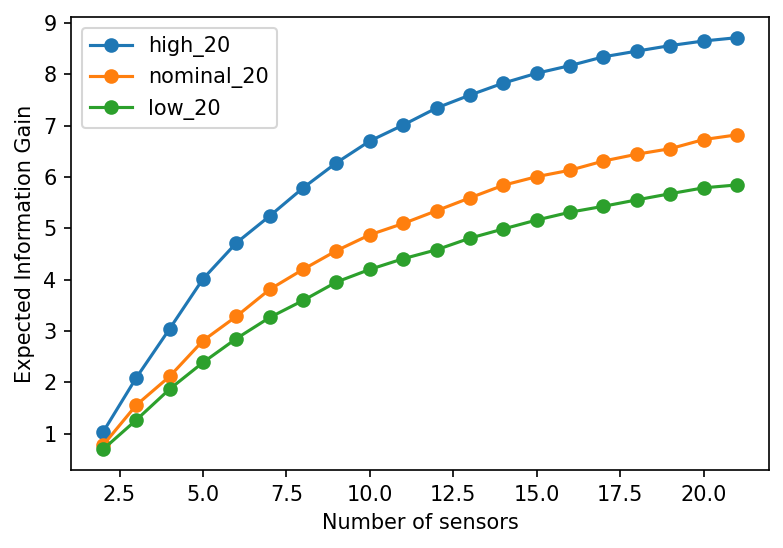

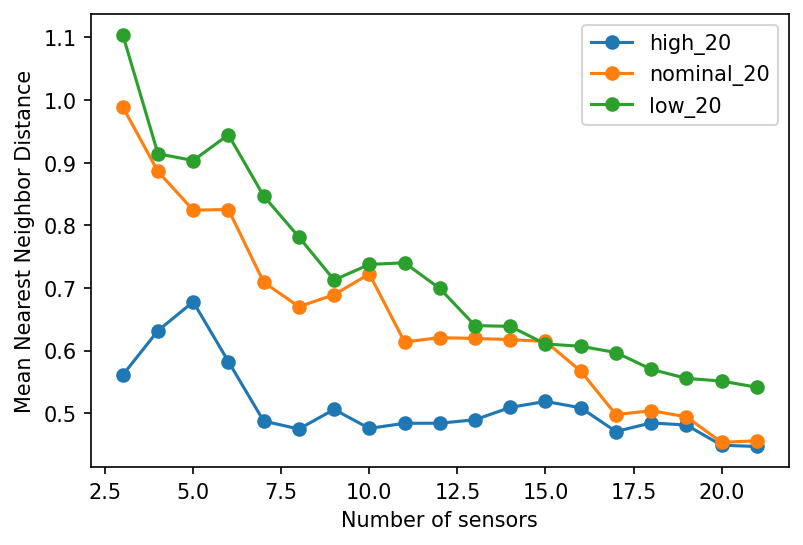

In [8]:
# Store eigs from 3 different runs
high20_eigs = []
nom20_eigs = []
low20_eigs = []

# Store mean nearest neighbor distance from 3 different runs
high_dists = []
nom_dists = []
low_dists = []

for i in range(2,22):
    # High_20 run:
    res = np.load(f'/ascldap/users/tacatan/hpc_home/seismic_oed/high_20/result_eigdata{i}.npz')
    eig = np.max(res['eigdata_full'][:,0]) # store eig
    high20_eigs.append(eig)
    
    # Calculate and store mean nearest neighbor distance when possible
    if i>2:
        locs = res['sensors'][:,:2]
        nn = NearestNeighbors().fit(locs)
        dists, _ = nn.kneighbors(locs,2)
        mean_dist = dists[:,1].mean()
        high_dists.append(mean_dist)
 
    # Nominal_20 run:
    res = np.load(f'/ascldap/users/tacatan/hpc_home/seismic_oed/nominal_20/result_eigdata{i}.npz')
    eig = np.max(res['eigdata_full'][:,0]) # Store eig
    nom20_eigs.append(eig)
    
    # Calculate and store mean nearest neighbor distance when possible
    if i>2:
        locs = res['sensors'][:,:2]
        nn = NearestNeighbors().fit(locs)
        dists, _ = nn.kneighbors(locs,2)
        mean_dist = dists[:,1].mean()
        nom_dists.append(mean_dist)
    
    # Low_20 run:
    res = np.load(f'/ascldap/users/tacatan/hpc_home/seismic_oed/low_20/result_eigdata{i}.npz')
    eig = np.max(res['eigdata_full'][:,0])  # Store eig  
    low20_eigs.append(eig)
    
    # Calculate and store mean nearest neighbor distance when possible
    if i>2:
        locs = res['sensors'][:,:2]
        nn = NearestNeighbors().fit(locs)
        dists, _ = nn.kneighbors(locs,2)
        mean_dist = dists[:,1].mean()
        low_dists.append(mean_dist)

# Plot eig by number of sensors
plt.figure(dpi=150)
plt.plot(np.arange(2,22),high20_eigs,marker='o', label='high_20')
plt.plot(np.arange(2,22),nom20_eigs,marker='o', label='nominal_20')
plt.plot(np.arange(2,22),low20_eigs,marker='o', label='low_20')
plt.xlabel('Number of sensors')
plt.ylabel('Expected Information Gain')
plt.legend()
plt.show()

# Plot mean nearest neighbor distance by number of sensors
plt.figure(dpi=150)
plt.plot(np.arange(3,22),high_dists,marker='o', label='high_20')
plt.plot(np.arange(3,22),nom_dists,marker='o', label='nominal_20')
plt.plot(np.arange(3,22),low_dists,marker='o', label='low_20')
plt.xlabel('Number of sensors')
plt.ylabel('Mean Nearest Neighbor Distance')
plt.legend()
plt.show()